### MNIST with Keras CNN + BN & DataAugment (99.X%)

In [1]:
import tensorflow as tf
from tensorflow.keras import datasets, utils
from tensorflow.keras import models, layers, activations, initializers, losses, optimizers, metrics

import numpy as np
import pandas as pd

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # https://stackoverflow.com/questions/35911252/disable-tensorflow-debugging-information

<br> 

#### 1. Prepare train & test data (MNIST)

#### Train & Test split

In [2]:
(train_data, train_label), (test_data, test_label) = datasets.mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


#### Normalization

In [3]:
# CNN에서는 [28행 x 28열]을 [1행 x 784열]로 펼쳐주지 않아도 됩니다.
# 다만 이미지의 채널에 해당하는 차원을 마지막 차원으로 새로이 추가해줍니다. (MNIST는 흑백 이미지이므로 채널 수를 1로 지정합니다.)

train_data = train_data.reshape(60000, 28, 28, 1) / 255.0 
test_data = test_data.reshape(10000, 28, 28, 1) / 255.0

#### One-hot encoding

In [4]:
train_label = utils.to_categorical(train_label) # 0~9 -> one-hot vector
test_label = utils.to_categorical(test_label) # 0~9 -> one-hot vector

<br> 

#### 2. Build the model & Set the criterion

In [5]:
# 3 steps of Convolutional Neural Network
# 1. Convolution (+ Batch Normalization)
# 2. Activation
# 3. (Max) Pooling
# * Repeat 1~3 for adding more hidden layers.
# 4. Connect the network to a fully-connected network (+ Dropout)
# * This fully-connected network makes the model can result in classification.


model = models.Sequential()


model.add(layers.Conv2D(32, (3, 3), input_shape=(28, 28, 1))) # Filter의 갯수, Filter의 shape, X data point의 shape (이미지 "1장"에 해당)
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))

model.add(layers.Conv2D(32, (3, 3)))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))

model.add(layers.MaxPooling2D(pool_size=(2, 2)))


model.add(layers.Conv2D(64, (3, 3)))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))

model.add(layers.Conv2D(64, (3, 3)))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))

model.add(layers.MaxPooling2D(pool_size=(2, 2)))


# Fully-connected network
model.add(layers.Flatten()) # 전체 차원을 펼쳐줍니다.

model.add(layers.Dense(512))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Dropout(rate=0.3))

model.add(layers.Dense(10, activation='softmax'))

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 26, 26, 32)       128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 26, 26, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 24, 24, 32)       128       
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 24, 24, 32)        0

In [7]:
# !pip install visualkeras==0.0.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 989 kB 5.0 MB/s 


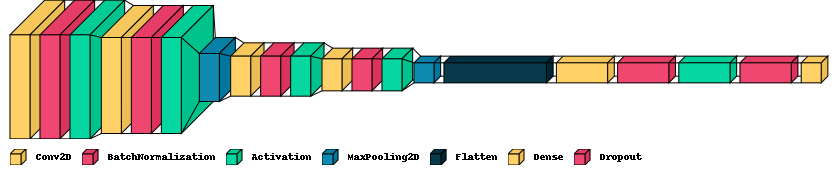

In [8]:
import visualkeras # https://github.com/paulgavrikov/visualkeras
from PIL import ImageFont

visualkeras.layered_view(model, legend=True) # font is optional

In [9]:
model.compile(optimizer=optimizers.Adam(), 
              loss=losses.categorical_crossentropy, 
              metrics=[metrics.categorical_accuracy]) # Precision / Recall / F1-Score 적용하기 @ https://j.mp/3cf3lbi

# model.compile(optimizer='adam', 
#               loss=losses.categorical_crossentropy, 
#               metrics=['accuracy'])

<br> 

#### 3. Train the model

**<span style='color:red; font-size:1.3em;'>ImageDataGenerator</span>** 를 활용하면 (Shift + Tab 참고)
<br><br>
\- 다양한 **Data augmentation**을 적용할 수 있습니다.
<br>
\- **rescale** 역시도 사전에 적용하지 않고 이 시점에 적용이 가능합니다. (ex. 1/255)
<br>
\- **flow_from_directory()** 메서드를 사용하면 <span style='color:blue;'>**이미지 데이터 폴더로부터 direct하게 데이터를 가져와 training에 활용**</span>할 수도 있습니다.<br>-> 참고 : [ <span style='color:green;'>(Appendix) 2. Build, Train, and Visualize CNN models (CNN Basic)</span> ] > [ <span style='color:green;'>4. Use ImageDataGenerator for CNN models (for color-images).ipynb</span> ] 

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


gen_train = ImageDataGenerator(rotation_range=8,        # Degree range for random rotations.
                               shear_range=0.3,         # Shear Intensity (Shear angle in counter-clockwise direction in degrees)
                               width_shift_range=0.08,  # Fraction of total width
                               height_shift_range=0.08, # Fraction of total height
                               zoom_range=0.08)         # Range for random zoom ([lower, upper] = [1-zoom_range, 1+zoom_range])

train_generator = gen_train.flow(train_data, train_label, batch_size=64) # flow_from_directory() 활용 가능


gen_test = ImageDataGenerator() # Test data에는 Augmentation을 적용하지 않습니다.

test_generator = gen_test.flow(test_data, test_label, batch_size=64)

In [11]:
# Epoch 당 Batch 수 (batch_size == 64)

60000 // 64

937

In [12]:
# history = model.fit(train_data, train_label, batch_size=100, epochs=15, validation_data=(test_data, test_label))

history = model.fit(train_generator, 
                    steps_per_epoch=60000 // 64, # == number of batches
                    epochs=5, 
                    validation_data=test_generator, 
                    validation_steps=10000 // 64)

Epoch 1/5
937/937 [==============================] - 30s 20ms/step - loss: 0.1385 - categorical_accuracy: 0.9570 - val_loss: 0.0614 - val_categorical_accuracy: 0.9818
Epoch 2/5
937/937 [==============================] - 18s 20ms/step - loss: 0.0565 - categorical_accuracy: 0.9823 - val_loss: 0.0349 - val_categorical_accuracy: 0.9892
Epoch 3/5
937/937 [==============================] - 18s 19ms/step - loss: 0.0476 - categorical_accuracy: 0.9850 - val_loss: 0.0276 - val_categorical_accuracy: 0.9904
Epoch 4/5
937/937 [==============================] - 18s 19ms/step - loss: 0.0395 - categorical_accuracy: 0.9879 - val_loss: 0.0337 - val_categorical_accuracy: 0.9885
Epoch 5/5
937/937 [==============================] - 18s 19ms/step - loss: 0.0370 - categorical_accuracy: 0.9885 - val_loss: 0.0226 - val_categorical_accuracy: 0.9930


<br> 

#### 4. Test the model

In [ ]:
result = model.evaluate(test_data, test_label, batch_size=100)

print('loss (cross-entropy) :', result[0])
print('test accuracy :', result[1])

100/100 [==============================] - 5s 47ms/step - loss: 0.0340 - categorical_accuracy: 0.9903
loss (cross-entropy) : 0.0339917428791523
test accuracy : 0.9902999997138977


In [ ]:
# 모델 예측 결과

np.argmax(model.predict(test_data[:10]), axis=1)

array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9], dtype=int64)

In [ ]:
# 실제 정답

np.argmax(test_label[:10], axis=1)

array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9], dtype=int64)

<br> 

#### 5. Visualize the result

In [ ]:
history.history.keys()

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])

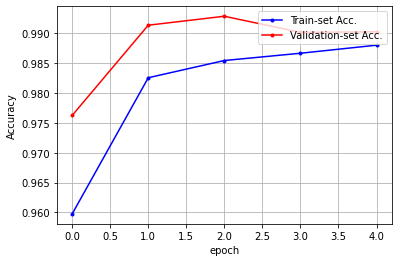

In [ ]:
val_acc = history.history['val_categorical_accuracy']
acc = history.history['categorical_accuracy']

import numpy as np
import matplotlib.pyplot as plt

x_len = np.arange(len(acc))
plt.plot(x_len, acc, marker='.', c='blue', label="Train-set Acc.")
plt.plot(x_len, val_acc, marker='.', c='red', label="Validation-set Acc.")

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.show()